In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os
from PIL import Image

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5]*3, std = [0.5]*3)
])

In [ ]:
class ImageFolderCustom(Dataset):
  def __init__(self, root_dir, transform = None):
    self.image_paths = [os.path.join(root_dir, fname)
                        for fname in os.listdir(root_dir)
                        if fname.endswith('.jpg') or fname.endswith('.png')]
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img = Image.open(self.image_paths[idx]).convert('RGB')
    if self.transform:
      return self.transform(img)
    return img

In [ ]:
train_horse_dir = '/content/drive/MyDrive/archive/trainA'
train_zebra_dir = '/content/drive/MyDrive/archive/trainB'

In [ ]:
train_horse = ImageFolderCustom(train_horse_dir, transform)
train_zebra = ImageFolderCustom(train_zebra_dir, transform)

In [ ]:
train_horse_loader = DataLoader(train_horse, batch_size = 1, shuffle = True)
train_zebra_loader = DataLoader(train_zebra, batch_size = 1, shuffle = True)

In [ ]:
len(train_horse_loader)

1067

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.block = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(channels, channels, kernel_size = 3, stride = 1, padding = 0),
        nn.InstanceNorm2d(channels),
        nn.ReLU(inplace = True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(channels, channels, kernel_size = 3, stride = 1, padding = 0),
        nn.InstanceNorm2d(channels)
    )

  def forward(self, x):
    return x + self.block(x)

In [ ]:
class GeneratorNetwork(nn.Module):
  def __init__(self, inupt_channel = 3, output_channel = 3, n_residual_block = 3):
    super().__init__()
    model = []


    #c7s1-64
    model += [

        nn.ReflectionPad2d(3),
        nn.Conv2d(inupt_channel, 64, kernel_size = 7, stride = 1, padding = 0),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace = True)
    ]

    model += [

        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace = True),

        nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace = True)
    ]

    for _ in range(n_residual_block):
      model += [ResidualBlock(256)]

    model += [
        nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace = True)
    ]

    model += [
        nn.ReflectionPad2d(3),
        nn.Conv2d(64, output_channel, kernel_size = 7, stride = 1, padding = 0),
        nn.Tanh()
    ]

    self.model = nn.Sequential(*model)

  def forward(self,x):
    return self.model(x)


In [ ]:
network = GeneratorNetwork()

In [ ]:
network.to(device)

GeneratorNetwork(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
       

In [ ]:
from torchsummary import summary
summary(network, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 134, 134]               0
            Conv2d-2         [-1, 64, 128, 128]           9,472
    InstanceNorm2d-3         [-1, 64, 128, 128]               0
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-6          [-1, 128, 64, 64]               0
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         295,168
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
             ReLU-10          [-1, 256, 32, 32]               0
  ReflectionPad2d-11          [-1, 256, 34, 34]               0
           Conv2d-12          [-1, 256, 32, 32]         590,080
   InstanceNorm2d-13          [-1, 256, 32, 32]               0
             ReLU-14          [-1, 256,

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, stride, num_filters):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, num_filters, kernel_size = 4, stride = 2, padding = 0),
        nn.InstanceNorm2d(num_filters),
        nn.LeakyReLU(inplace = True)
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
class DiscriminatorNetwork(nn.Module):
  def __init__(self, input_channel = 3):
    super().__init__()
    self.features = nn.Sequential(
        ConvBlock(input_channel, stride = 2, num_filters = 64),
        ConvBlock(64, stride = 2, num_filters = 128),
        ConvBlock(128, stride = 2, num_filters = 256),
        ConvBlock(256, stride = 2, num_filters = 512),
        nn.Flatten(),
        )
    dummy_var = torch.randn(1,3,128,128)
    with torch.no_grad():
      out = self.features(dummy_var)
      size = out.shape[1]

    self.output_layer = nn.Linear(size, 1)

  def forward(self, x):
    x = self.features(x)
    x = self.output_layer(x)

    return x


In [ ]:
discriminator_network = DiscriminatorNetwork()

In [ ]:
summary(discriminator_network, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           3,136
    InstanceNorm2d-2           [-1, 64, 63, 63]               0
         LeakyReLU-3           [-1, 64, 63, 63]               0
         ConvBlock-4           [-1, 64, 63, 63]               0
            Conv2d-5          [-1, 128, 30, 30]         131,200
    InstanceNorm2d-6          [-1, 128, 30, 30]               0
         LeakyReLU-7          [-1, 128, 30, 30]               0
         ConvBlock-8          [-1, 128, 30, 30]               0
            Conv2d-9          [-1, 256, 14, 14]         524,544
   InstanceNorm2d-10          [-1, 256, 14, 14]               0
        LeakyReLU-11          [-1, 256, 14, 14]               0
        ConvBlock-12          [-1, 256, 14, 14]               0
           Conv2d-13            [-1, 512, 6, 6]       2,097,664
   InstanceNorm2d-14            [-1, 51

In [ ]:
G_horse_zebra = GeneratorNetwork().to(device)
G_zebra_horse = GeneratorNetwork().to(device)
D_zebra = DiscriminatorNetwork().to(device)
D_horse = DiscriminatorNetwork().to(device)

In [ ]:
mse_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()

In [ ]:
class Reply_buffer():
  def __init__(self, max_size = 50):
    self.buffer = []
    self.max_size = max_size

  def push_and_pop(self, data):
    returned = []
    for ele in data:
      if len(self.buffer) < self.max_size:
        self.buffer.append(ele)
        returned.append(ele)
      else:
        if torch.rand(1).item() > 0.5:
          idx = torch.randint(0, len(self.buffer), (1,)).item()
          old = self.buffer[idx]
          returned.append(old)
          self.buffer[idx] = ele
        else:
          returned.append(ele)
    return torch.stack(returned)

In [ ]:
buffer_horse = Reply_buffer()
buffer_zebra = Reply_buffer()

In [ ]:
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(list(G_horse_zebra.parameters()) + list(G_zebra_horse.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_zebra = optim.Adam(D_zebra.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_horse = optim.Adam(D_horse.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import os
import torch

checkpoint_path = "/content/checkpoint.pth"

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    G_horse_zebra.load_state_dict(checkpoint['G_horse_zebra_state_dict'])
    G_zebra_horse.load_state_dict(checkpoint['G_zebra_horse_state_dict'])
    D_zebra.load_state_dict(checkpoint['D_zebra_state_dict'])
    D_horse.load_state_dict(checkpoint['D_horse_state_dict'])

    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_zebra.load_state_dict(checkpoint['optimizer_D_zebra_state_dict'])
    optimizer_D_horse.load_state_dict(checkpoint['optimizer_D_horse_state_dict'])

    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

epochs = 10
for i in range(start_epoch, epochs):
    for horse_image, zebra_image in zip(train_horse_loader, train_zebra_loader):
        horse_image, zebra_image = horse_image.to(device), zebra_image.to(device)
        fake_zebra = G_horse_zebra(horse_image)
        fake_horse = G_zebra_horse(zebra_image)
        recov_horse = G_zebra_horse(fake_zebra)
        recov_zebra = G_horse_zebra(fake_horse)

        loss_GAN_horse_zebra = mse_loss(D_zebra(fake_zebra), torch.ones_like(D_zebra(fake_zebra)))
        loss_GAN_zebra_horse = mse_loss(D_horse(fake_horse), torch.ones_like(D_horse(fake_horse)))
        loss_cycle_horse = cycle_loss(recov_horse, horse_image)
        loss_cycle_zebra = cycle_loss(recov_zebra, zebra_image)

        loss_G = loss_GAN_horse_zebra + loss_GAN_zebra_horse + 10 * (loss_cycle_horse + loss_cycle_zebra)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Discriminator Zebra
        fake_zebra_buffered = buffer_zebra.push_and_pop(fake_zebra)
        loss_D_zebra_real = mse_loss(D_zebra(zebra_image), torch.ones_like(D_zebra(zebra_image)))
        loss_D_zebra_fake = mse_loss(D_zebra(fake_zebra_buffered.detach()), torch.zeros_like(D_zebra(fake_zebra_buffered)))
        loss_D_zebra = 0.5 * (loss_D_zebra_real + loss_D_zebra_fake)

        optimizer_D_zebra.zero_grad()
        loss_D_zebra.backward()
        optimizer_D_zebra.step()

        # Discriminator Horse
        fake_horse_buffered = buffer_horse.push_and_pop(fake_horse)
        loss_D_horse_real = mse_loss(D_horse(horse_image), torch.ones_like(D_horse(horse_image)))
        loss_D_horse_fake = mse_loss(D_horse(fake_horse_buffered.detach()), torch.zeros_like(D_horse(fake_horse_buffered)))
        loss_D_horse = 0.5 * (loss_D_horse_real + loss_D_horse_fake)

        optimizer_D_horse.zero_grad()
        loss_D_horse.backward()
        optimizer_D_horse.step()

        print(f"epoch : {i} Generator loss: {loss_G.item():.4f}, Discriminator A: {loss_D_zebra.item():.4f}, Discriminator B: {loss_D_horse.item():.4f}")

    # Save checkpoint at the end of each epoch
    torch.save({
        'epoch': i,
        'G_horse_zebra_state_dict': G_horse_zebra.state_dict(),
        'G_zebra_horse_state_dict': G_zebra_horse.state_dict(),
        'D_zebra_state_dict': D_zebra.state_dict(),
        'D_horse_state_dict': D_horse.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_zebra_state_dict': optimizer_D_zebra.state_dict(),
        'optimizer_D_horse_state_dict': optimizer_D_horse.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {i}")


Streaming output truncated to the last 5000 lines.
epoch : 5 Generator loss: 4.2990, Discriminator A: 1.4041, Discriminator B: 1.0483
epoch : 5 Generator loss: 6.5499, Discriminator A: 0.3877, Discriminator B: 0.1501
epoch : 5 Generator loss: 4.4012, Discriminator A: 0.5214, Discriminator B: 0.2294
epoch : 5 Generator loss: 6.2626, Discriminator A: 0.4232, Discriminator B: 0.3379
epoch : 5 Generator loss: 3.9342, Discriminator A: 1.3251, Discriminator B: 0.8970
epoch : 5 Generator loss: 4.6630, Discriminator A: 0.3084, Discriminator B: 0.1849
epoch : 5 Generator loss: 10.5028, Discriminator A: 0.3523, Discriminator B: 2.9025
epoch : 5 Generator loss: 8.0733, Discriminator A: 0.3339, Discriminator B: 3.0463
epoch : 5 Generator loss: 5.7090, Discriminator A: 0.4766, Discriminator B: 0.2757
epoch : 5 Generator loss: 3.4763, Discriminator A: 0.6190, Discriminator B: 0.0492
epoch : 5 Generator loss: 5.7609, Discriminator A: 0.5766, Discriminator B: 0.0356
epoch : 5 Generator loss: 5.0241, D

In [ ]:
G_horse_zebra.eval()
img = Image.open("/content/drive/MyDrive/archive/testA/n02381460_1110.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

In [ ]:
with torch.no_grad():
    fake_img = G_horse_zebra(input_tensor)  # Convert horse to zebra

# Convert back to image format
output = fake_img.squeeze().detach().to(device)
output = (output + 1) / 2  # Denormalize from [-1,1] to [0,1]

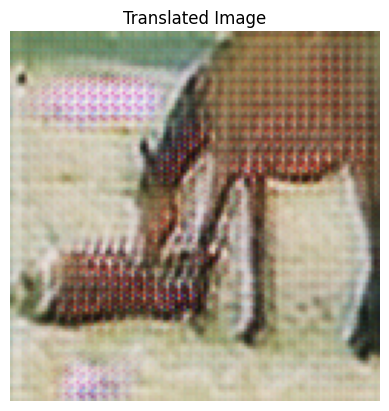

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Move the output tensor to the CPU before plotting and saving
plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.title("Translated Image")
plt.axis("off")
plt.show()

# Save the image
from torchvision.utils import save_image
save_image(output.cpu(), "output_image.jpg")